In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import os
import pickle

In [2]:
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

TRAINED_MODEL_PATH = 'trained_resnet18_mnist.pth'
IMPORTANCE_DICT_PATH = 'importance_dict_resnet18.pkl'

# Hyperparameters
CLASSES = [0, 1, 2, 3]
FORGET_CLASS = 0
BATCH_SIZE = 128  # Larger batch size for ResNet
TRAIN_EPOCHS = 15  # More epochs for ResNet
TOP_K_FRACTION = 0.05  # Top 5% (ResNet has more parameters)
LAMBDA_DECAY = 0.15
DECAY_STEPS = 20
FINETUNE_LR = 0.0001
FINE_TUNE = True
FINE_TUNE_AFTER_EACH_STEP = True
FINE_TUNE_EPOCH_COUNT = 10
SAMPLE_RATE = 0.3  # Sample 30% of filters for importance computation



TRAINED_MODEL_PATH = './resnet/resnet_trained_mnist.pth'
IMPORTANCE_DICT_PATH = './resnet_importance_dict.pkl'
dirpath = os.path.dirname(TRAINED_MODEL_PATH)
if dirpath:
    os.makedirs(dirpath, exist_ok=True)
dirpath= os.path.dirname(IMPORTANCE_DICT_PATH)
if dirpath:
    os.makedirs(dirpath, exist_ok=True)

Using device: cuda


In [3]:

# ================================
# 1. ResNet-18 Architecture (Modified for MNIST)
# ================================
def create_resnet18_mnist(num_classes=4):
    """
    Create ResNet-18 modified for MNIST (grayscale, 28x28)
    """
    model = resnet18(pretrained=False)

    # Modify first conv layer for grayscale (1 channel instead of 3)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Modify final fc layer for our number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


# ================================
# 2. Data Loading and Preparation
# ================================
def load_mnist_subset(classes=[0, 1, 2, 3]):
    """Load MNIST dataset with only specified classes"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load full datasets
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    # Filter for specific classes
    train_indices = [i for i, (_, label) in enumerate(train_dataset) if label in classes]
    test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in classes]

    train_subset = Subset(train_dataset, train_indices)
    test_subset = Subset(test_dataset, test_indices)

    return train_subset, test_subset


def create_forget_retain_splits(dataset, forget_class=0, is_train=True):
    """
    Split dataset into forget and retain sets

    Args:
        dataset: The dataset to split
        forget_class: The class to forget
        is_train: Whether this is training data (True) or test data (False)

    Returns:
        forget_subset, retain_subset
    """
    forget_indices = []
    retain_indices = []

    for i, (_, label) in enumerate(dataset):
        if label == forget_class:
            forget_indices.append(i)
        else:
            retain_indices.append(i)

    forget_subset = Subset(dataset, forget_indices)
    retain_subset = Subset(dataset, retain_indices)

    if is_train:
        print(f"  Training - Forget class samples: {len(forget_indices)}")
        print(f"  Training - Retain classes samples: {len(retain_indices)}")
    else:
        print(f"  Test - Forget class samples: {len(forget_indices)}")
        print(f"  Test - Retain classes samples: {len(retain_indices)}")

    return forget_subset, retain_subset


# ================================
# 3. Training Functions
# ================================
def train_model(model, train_loader, num_epochs=10, lr=0.001):
    """Train the model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1),
                                      'acc': 100. * correct / total})

    return model


def evaluate_model(model, data_loader, class_wise=False):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if class_wise:
                for label, pred in zip(labels, predicted):
                    label_item = label.item()
                    if label_item not in class_correct:
                        class_correct[label_item] = 0
                        class_total[label_item] = 0
                    class_total[label_item] += 1
                    if label == pred:
                        class_correct[label_item] += 1

    accuracy = 100. * correct / total

    if class_wise:
        class_accuracies = {k: 100. * class_correct[k] / class_total[k]
                            for k in class_correct.keys()}
        return accuracy, class_accuracies

    return accuracy


# ================================
# 4. Weight Importance Estimation (ResNet-specific)
# ================================
def compute_weight_importance_resnet(model, forget_loader):
    """
    Compute importance of each weight/filter by measuring accuracy drop
    when that weight/filter is removed.

    For ResNet, we handle:
    - Conv layers in residual blocks
    - Batch norm layers
    - Skip connections (downsample layers)
    - Final FC layer

    Args:
        model: ResNet model
        forget_loader: DataLoader for forget class

    Returns:
        importance_dict: Dictionary mapping (layer_name, index) -> importance_score
    """
    print("\n" + "=" * 60)
    print("COMPUTING WEIGHT IMPORTANCE FOR FORGET CLASS (ResNet-18)")
    print("=" * 60)

    model.eval()
    importance_dict = {}

    # Get baseline accuracy on forget class
    baseline_acc = evaluate_model(model, forget_loader)
    print(f"\nBaseline accuracy on forget class: {baseline_acc:.2f}%")

    # Track layers to analyze
    layers_to_analyze = []

    # Iterate through all modules
    for name, module in model.named_modules():
        # Focus on Conv2d and Linear layers
        if isinstance(module, nn.Conv2d):
            layers_to_analyze.append((name, module, 'conv'))
        elif isinstance(module, nn.Linear):
            layers_to_analyze.append((name, module, 'linear'))

    print(f"\nTotal layers to analyze: {len(layers_to_analyze)}")

    # Analyze each layer
    for name, module, layer_type in layers_to_analyze:
        if layer_type == 'conv':
            print(f"\n[CONV LAYER] {name}: {module.weight.shape}")
            num_filters = module.weight.shape[0]

            print(f"  Evaluating ALL {num_filters} filters")

            for filter_idx in tqdm(range(num_filters), desc=f"  Evaluating {name}"):
                # Save original filter
                original_filter = module.weight.data[filter_idx].clone()

                # Zero out the filter
                module.weight.data[filter_idx].zero_()

                # Measure accuracy drop
                new_acc = evaluate_model(model, forget_loader)
                importance = baseline_acc - new_acc

                # Restore filter
                module.weight.data[filter_idx] = original_filter

                # Store importance
                importance_dict[(name, filter_idx)] = importance

        elif layer_type == 'linear':
            print(f"\n[FC LAYER] {name}: {module.weight.shape}")
            num_neurons = module.weight.shape[0]

            print(f"  Evaluating ALL {num_neurons} neurons")

            for neuron_idx in tqdm(range(num_neurons), desc=f"  Evaluating {name}"):
                # Save original neuron weights
                original_weights = module.weight.data[neuron_idx].clone()
                if module.bias is not None:
                    original_bias = module.bias.data[neuron_idx].clone()

                # Zero out the neuron
                module.weight.data[neuron_idx].zero_()
                if module.bias is not None:
                    module.bias.data[neuron_idx].zero_()

                # Measure accuracy drop
                new_acc = evaluate_model(model, forget_loader)
                importance = baseline_acc - new_acc

                # Restore neuron
                module.weight.data[neuron_idx] = original_weights
                if module.bias is not None:
                    module.bias.data[neuron_idx] = original_bias

                # Store importance
                importance_dict[(name, neuron_idx)] = importance

    return importance_dict


def select_top_k_important(importance_dict, k=0.1):
    """
    Select top k% of most important weights/filters

    Args:
        importance_dict: Dictionary of importance scores
        k: Fraction of weights to select (0 to 1)

    Returns:
        List of (layer_name, index) tuples for top k weights
    """
    # Sort by importance (descending)
    sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Select top k%
    num_to_select = max(1, int(len(sorted_items) * k))
    top_k = [item[0] for item in sorted_items[:num_to_select]]

    print(f"\n{'=' * 60}")
    print(f"SELECTED TOP {k * 100:.1f}% IMPORTANT WEIGHTS")
    print(f"Total weights analyzed: {len(importance_dict)}")
    print(f"Selected: {num_to_select}")
    print(f"{'=' * 60}")
    print("\nTop 20 most important:")
    for i, (key, importance) in enumerate(sorted_items[:20]):
        print(f"  {i + 1}. {key[0]}[{key[1]}]: {importance:.4f}% accuracy drop")

    return top_k


# ================================
# 5. Time-Decay Unlearning (Same as LeNet)
# ================================
def apply_time_decay(model, top_k_weights, lambda_decay=0.1, num_steps=10,
                     forget_loader=None, retain_loader=None, finetune_lr=0.0001, finetune=False,
                     finetune_after_each_step=True, fine_tune_epoch_count=5):
    """
    Apply exponential time decay to selected weights over multiple steps

    Args:
        model: Neural network model
        top_k_weights: List of (layer_name, index) tuples
        lambda_decay: Decay rate
        num_steps: Number of decay steps to perform
        forget_loader: DataLoader for forget set (for evaluation)
        retain_loader: DataLoader for retain set (for fine-tuning)
        finetune_lr: Learning rate for fine-tuning
        finetune: Whether to finetune
        finetune_after_each_step: Whether to finetune after each decay step
        fine_tune_epoch_count: Number of epochs for final finetuning

    Returns:
        model: Updated model
        history: Dictionary with decay history
    """
    print(f"\n{'=' * 60}")
    print(f"APPLYING TIME-DECAY UNLEARNING")
    print(f"Lambda: {lambda_decay}, Steps: {num_steps}")
    print(f"{'=' * 60}")

    history = {
        'step': [],
        'forget_acc': [],
        'retain_acc': []
    }

    # Group weights by layer for efficient access
    layer_dict = dict(model.named_modules())

    # Main decay loop
    for step in range(num_steps):
        print(f"\n--- Decay Step {step + 1}/{num_steps} ---")

        # Apply decay to selected weights
        with torch.no_grad():
            for layer_name, idx in top_k_weights:
                layer = layer_dict[layer_name]

                if isinstance(layer, (nn.Conv2d, nn.Linear)):
                    # Apply decay: θ(t+Δt) = θ(t) * e^(-λΔt)
                    decay_factor = np.exp(-lambda_decay * 1.0)
                    layer.weight.data[idx] *= decay_factor

                    if layer.bias is not None and idx < layer.bias.shape[0]:
                        layer.bias.data[idx] *= decay_factor

        # Optional: Fine-tune on retain set to maintain performance
        if retain_loader and finetune and finetune_after_each_step:
            model.train()
            optimizer = optim.Adam(model.parameters(), lr=finetune_lr)
            criterion = nn.CrossEntropyLoss()

            # One pass through retain set
            for inputs, labels in retain_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate after this decay step
        model.eval()

        if forget_loader is not None:
            forget_acc = evaluate_model(model, forget_loader)
            history['forget_acc'].append(forget_acc)
            print(f"  Forget Accuracy: {forget_acc:.2f}%")

        if retain_loader is not None:
            retain_acc = evaluate_model(model, retain_loader)
            history['retain_acc'].append(retain_acc)
            print(f"  Retain Accuracy: {retain_acc:.2f}%")

        history['step'].append(step + 1)

        # Early stopping if forget accuracy is low enough
        if forget_loader is not None and forget_acc < 5.0:
            print(f"\n✓ Target forget accuracy (<5%) reached! Stopping early.")
            break

    # Final finetuning if requested
    if retain_loader and finetune and not finetune_after_each_step:
        print("\n" + "=" * 60)
        print("FINETUNING AFTER ALL DECAY STEPS")
        print("=" * 60)

        optimizer = optim.Adam(model.parameters(), lr=finetune_lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(fine_tune_epoch_count):
            model.train()
            print(f"\n--- Finetune Epoch {epoch + 1}/{fine_tune_epoch_count} ---")

            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in retain_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            model.eval()
            retain_acc = evaluate_model(model, retain_loader)
            forget_acc = evaluate_model(model, forget_loader)
            print(f"  Loss: {running_loss / len(retain_loader):.4f}")
            print(f"  Retain Accuracy: {retain_acc:.2f}%")
            print(f"  Forget Accuracy: {forget_acc:.2f}%")

    model.eval()
    return model, history


# ================================
# 6. Visualization Functions
# ================================
def plot_results(history, save_name='unlearning_results_resnet18.png'):
    """Plot unlearning results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot forget accuracy
    ax1.plot(history['step'], history['forget_acc'], 'r-o', label='Forget Class')
    ax1.set_xlabel('Decay Step')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Forget Class Accuracy (Should Decrease)')
    ax1.grid(True)
    ax1.legend()

    # Plot retain accuracy
    ax2.plot(history['step'], history['retain_acc'], 'b-o', label='Retain Classes')
    ax2.set_xlabel('Decay Step')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Retain Classes Accuracy (Should Stay High)')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(save_name, dpi=150)
    plt.show()

    print(f"\nPlot saved as '{save_name}'")


def visualize_weight_importance(importance_dict, top_n=30, save_name='weight_importance_resnet18.png'):
    """Visualize top N most important weights"""
    sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    top_items = sorted_items[:top_n]

    labels = [f"{k[0]}[{k[1]}]" for k, v in top_items]
    values = [v for k, v in top_items]

    plt.figure(figsize=(14, 8))
    plt.barh(range(len(labels)), values)
    plt.yticks(range(len(labels)), labels, fontsize=7)
    plt.xlabel('Importance (Accuracy Drop %)')
    plt.title(f'Top {top_n} Most Important Weights for Forget Class (ResNet-18)')
    plt.tight_layout()
    plt.savefig(save_name, dpi=150)
    plt.show()

    print(f"\nWeight importance plot saved as '{save_name}'")


# ================================
# 7. Main Execution Pipeline
# ================================
def main():
    print("=" * 60)
    print("TIME-DECAY UNLEARNING FOR RESNET-18 ON MNIST")
    print("=" * 60)



    print("\nHyperparameters:")
    print(f"Classes: {CLASSES}")
    print(f"Forget Class: {FORGET_CLASS}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Training Epochs: {TRAIN_EPOCHS}")
    print(f"Top-K Fraction: {TOP_K_FRACTION}")
    print(f"Lambda Decay: {LAMBDA_DECAY}")
    print(f"Decay Steps: {DECAY_STEPS}")
    print(f"Finetune Learning Rate: {FINETUNE_LR}")
    print(f"Fine-tuning Enabled: {FINE_TUNE}")
    print(f"Fine-tune After Each Step: {FINE_TUNE_AFTER_EACH_STEP}")
    print(f"Fine-tune Epoch Count: {FINE_TUNE_EPOCH_COUNT}")
    print(f"Filter Sample Rate (for importance): {SAMPLE_RATE}")

    # 1. Load data
    print("\n[STEP 1] Loading MNIST dataset...")
    train_dataset, test_dataset = load_mnist_subset(CLASSES)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    forget_train_dataset, retain_train_dataset = create_forget_retain_splits(
        train_dataset,
        forget_class=FORGET_CLASS,
        is_train=True
    )

    retain_train_loader = DataLoader(
        retain_train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    forget_train_loader = DataLoader(
        forget_train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Create forget/retain splits

    forget_test_dataset, retain_test_dataset = create_forget_retain_splits(
        test_dataset,
        forget_class=FORGET_CLASS,
        is_train=False
    )
    forget_test_loader = DataLoader(forget_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    retain_test_loader = DataLoader(retain_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Forget class ({FORGET_CLASS}) samples: {len(forget_train_dataset)}")
    print(f"Retain classes samples: {len(retain_train_dataset)}")

    if os.path.exists(TRAINED_MODEL_PATH):
        print(f"✓ Found existing trained model at '{TRAINED_MODEL_PATH}'")
        print(f"  Loading saved model...")
        model = create_resnet18_mnist(num_classes=len(CLASSES)).to(device)
        model.load_state_dict(torch.load(TRAINED_MODEL_PATH, map_location=device))
        print(f"  Model loaded successfully!")
    else:
        # 2. Train model
        print(f"\n[STEP 2] Training ResNet-18 on classes {CLASSES}...")
        model = create_resnet18_mnist(num_classes=len(CLASSES)).to(device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        model = train_model(model, train_loader, num_epochs=TRAIN_EPOCHS, lr=0.001)
        torch.save(model.state_dict(), TRAINED_MODEL_PATH)
        print(f"✓ Trained model saved to '{TRAINED_MODEL_PATH}'")

    # 3. Evaluate baseline
    print(f"\n[STEP 3] Evaluating baseline performance...")
    test_acc = evaluate_model(model, test_loader)
    forget_acc_before = evaluate_model(model, forget_test_loader)
    retain_acc_before = evaluate_model(model, retain_test_loader)

    print(f"\nBaseline Results:")
    print(f"  Overall Test Accuracy: {test_acc:.2f}%")
    print(f"  Forget Class ({FORGET_CLASS}) Accuracy: {forget_acc_before:.2f}%")
    print(f"  Retain Classes Accuracy: {retain_acc_before:.2f}%")

    # Save original model
    original_model = copy.deepcopy(model)

    # 4. Compute weight importance
    print(f"\n[STEP 4] Computing weight importance...")
    if os.path.exists(IMPORTANCE_DICT_PATH):
        print(f"✓ Found existing importance dictionary at '{IMPORTANCE_DICT_PATH}'")
        print(f"  Loading saved importance scores...")
        with open(IMPORTANCE_DICT_PATH, 'rb') as f:
            importance_dict = pickle.load(f)
        print(f"  Loaded {len(importance_dict)} weight importance scores!")
    else:
        print(f"✗ No existing importance dictionary found. Computing from scratch...")
        print(f"Note: This may take a while for ResNet-18...")
        importance_dict = compute_weight_importance_resnet(model, forget_train_loader)

        # Save importance dictionary
        with open(IMPORTANCE_DICT_PATH, 'wb') as f:
            pickle.dump(importance_dict, f)
        print(f"✓ Importance dictionary saved to '{IMPORTANCE_DICT_PATH}'")


    # Visualize importance
    visualize_weight_importance(importance_dict, top_n=30)

    # 5. Select top-k weights
    print(f"\n[STEP 5] Selecting top {TOP_K_FRACTION * 100}% important weights...")
    top_k_weights = select_top_k_important(importance_dict, k=TOP_K_FRACTION)

    # 6. Apply time-decay unlearning
    print(f"\n[STEP 6] Applying time-decay unlearning...")

    model, history = apply_time_decay(
        model,
        top_k_weights,
        lambda_decay=LAMBDA_DECAY,
        num_steps=DECAY_STEPS,
        forget_loader=forget_test_loader,
        retain_loader=retain_train_loader,
        finetune_lr=FINETUNE_LR,
        finetune=FINE_TUNE,
        finetune_after_each_step=FINE_TUNE_AFTER_EACH_STEP,
        fine_tune_epoch_count=FINE_TUNE_EPOCH_COUNT
    )

    # Add baseline to history for plotting
    history['step'] = [0] + history['step']
    history['forget_acc'] = [forget_acc_before] + history['forget_acc']
    history['retain_acc'] = [retain_acc_before] + history['retain_acc']

    # 7. Final evaluation
    print(f"\n{'=' * 60}")
    print("FINAL RESULTS")
    print(f"{'=' * 60}")

    forget_acc_after = evaluate_model(model, forget_test_loader)
    retain_acc_after = evaluate_model(model, retain_test_loader)
    test_acc_after = evaluate_model(model, test_loader)

    print(f"\nBefore Unlearning:")
    print(f"  Forget Class Accuracy: {forget_acc_before:.2f}%")
    print(f"  Retain Classes Accuracy: {retain_acc_before:.2f}%")
    print(f"  Overall Test Accuracy: {test_acc:.2f}%")

    print(f"\nAfter Unlearning:")
    print(f"  Forget Class Accuracy: {forget_acc_after:.2f}%")
    print(f"  Retain Classes Accuracy: {retain_acc_after:.2f}%")
    print(f"  Overall Test Accuracy: {test_acc_after:.2f}%")

    print(f"\nChanges:")
    print(
        f"  Forget Class: {forget_acc_before:.2f}% → {forget_acc_after:.2f}% (Δ {forget_acc_after - forget_acc_before:+.2f}%)")
    print(
        f"  Retain Classes: {retain_acc_before:.2f}% → {retain_acc_after:.2f}% (Δ {retain_acc_after - retain_acc_before:+.2f}%)")

    # 8. Plot results
    plot_results(history)

    # 9. Save model
    torch.save(model.state_dict(), 'unlearned_model_resnet18.pth')
    torch.save(original_model.state_dict(), 'original_model_resnet18.pth')
    print(f"\nModels saved:")
    print(f"  - unlearned_model_resnet18.pth")
    print(f"  - original_model_resnet18.pth")

    return model, original_model, history

TIME-DECAY UNLEARNING FOR RESNET-18 ON MNIST

Hyperparameters:
Classes: [0, 1, 2, 3]
Forget Class: 0
Batch Size: 128
Training Epochs: 15
Top-K Fraction: 0.05
Lambda Decay: 0.15
Decay Steps: 20
Finetune Learning Rate: 0.0001
Fine-tuning Enabled: True
Fine-tune After Each Step: True
Fine-tune Epoch Count: 10
Filter Sample Rate (for importance): 0.3

[STEP 1] Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


  Training - Forget class samples: 5923
  Training - Retain classes samples: 18831
  Test - Forget class samples: 980
  Test - Retain classes samples: 3177
Training samples: 24754
Test samples: 4157
Forget class (0) samples: 5923
Retain classes samples: 18831

[STEP 2] Training ResNet-18 on classes [0, 1, 2, 3]...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Total parameters: 11,172,292
Trainable parameters: 11,172,292


Epoch 15/15: 100%|██████████| 194/194 [00:06<00:00, 27.78it/s, loss=0.00335, acc=99.9]


✓ Trained model saved to './resnet/resnet_trained_mnist.pth'

[STEP 3] Evaluating baseline performance...

Baseline Results:
  Overall Test Accuracy: 99.81%
  Forget Class (0) Accuracy: 99.80%
  Retain Classes Accuracy: 99.81%

[STEP 4] Computing weight importance...
✗ No existing importance dictionary found. Computing from scratch...
Note: This may take a while for ResNet-18...

COMPUTING WEIGHT IMPORTANCE FOR FORGET CLASS (ResNet-18)

Baseline accuracy on forget class: 99.93%

Total layers to analyze: 21

[CONV LAYER] conv1: torch.Size([64, 1, 7, 7])
  Evaluating ALL 64 filters


  Evaluating conv1: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it]



[CONV LAYER] layer1.0.conv1: torch.Size([64, 64, 3, 3])
  Evaluating ALL 64 filters


  Evaluating layer1.0.conv1: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it]



[CONV LAYER] layer1.0.conv2: torch.Size([64, 64, 3, 3])
  Evaluating ALL 64 filters


  Evaluating layer1.0.conv2: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it]



[CONV LAYER] layer1.1.conv1: torch.Size([64, 64, 3, 3])
  Evaluating ALL 64 filters


  Evaluating layer1.1.conv1: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it]



[CONV LAYER] layer1.1.conv2: torch.Size([64, 64, 3, 3])
  Evaluating ALL 64 filters


  Evaluating layer1.1.conv2: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it]



[CONV LAYER] layer2.0.conv1: torch.Size([128, 64, 3, 3])
  Evaluating ALL 128 filters


  Evaluating layer2.0.conv1: 100%|██████████| 128/128 [02:41<00:00,  1.26s/it]



[CONV LAYER] layer2.0.conv2: torch.Size([128, 128, 3, 3])
  Evaluating ALL 128 filters


  Evaluating layer2.0.conv2: 100%|██████████| 128/128 [02:40<00:00,  1.25s/it]



[CONV LAYER] layer2.0.downsample.0: torch.Size([128, 64, 1, 1])
  Evaluating ALL 128 filters


  Evaluating layer2.0.downsample.0: 100%|██████████| 128/128 [02:40<00:00,  1.25s/it]



[CONV LAYER] layer2.1.conv1: torch.Size([128, 128, 3, 3])
  Evaluating ALL 128 filters


  Evaluating layer2.1.conv1: 100%|██████████| 128/128 [02:41<00:00,  1.26s/it]



[CONV LAYER] layer2.1.conv2: torch.Size([128, 128, 3, 3])
  Evaluating ALL 128 filters


  Evaluating layer2.1.conv2: 100%|██████████| 128/128 [02:39<00:00,  1.25s/it]



[CONV LAYER] layer3.0.conv1: torch.Size([256, 128, 3, 3])
  Evaluating ALL 256 filters


  Evaluating layer3.0.conv1: 100%|██████████| 256/256 [05:21<00:00,  1.26s/it]



[CONV LAYER] layer3.0.conv2: torch.Size([256, 256, 3, 3])
  Evaluating ALL 256 filters


  Evaluating layer3.0.conv2: 100%|██████████| 256/256 [05:22<00:00,  1.26s/it]



[CONV LAYER] layer3.0.downsample.0: torch.Size([256, 128, 1, 1])
  Evaluating ALL 256 filters


  Evaluating layer3.0.downsample.0: 100%|██████████| 256/256 [05:22<00:00,  1.26s/it]



[CONV LAYER] layer3.1.conv1: torch.Size([256, 256, 3, 3])
  Evaluating ALL 256 filters


  Evaluating layer3.1.conv1: 100%|██████████| 256/256 [05:24<00:00,  1.27s/it]



[CONV LAYER] layer3.1.conv2: torch.Size([256, 256, 3, 3])
  Evaluating ALL 256 filters


  Evaluating layer3.1.conv2: 100%|██████████| 256/256 [05:24<00:00,  1.27s/it]



[CONV LAYER] layer4.0.conv1: torch.Size([512, 256, 3, 3])
  Evaluating ALL 512 filters


  Evaluating layer4.0.conv1: 100%|██████████| 512/512 [10:46<00:00,  1.26s/it]



[CONV LAYER] layer4.0.conv2: torch.Size([512, 512, 3, 3])
  Evaluating ALL 512 filters


  Evaluating layer4.0.conv2: 100%|██████████| 512/512 [10:48<00:00,  1.27s/it]



[CONV LAYER] layer4.0.downsample.0: torch.Size([512, 256, 1, 1])
  Evaluating ALL 512 filters


  Evaluating layer4.0.downsample.0: 100%|██████████| 512/512 [10:49<00:00,  1.27s/it]



[CONV LAYER] layer4.1.conv1: torch.Size([512, 512, 3, 3])
  Evaluating ALL 512 filters


  Evaluating layer4.1.conv1: 100%|██████████| 512/512 [10:49<00:00,  1.27s/it]



[CONV LAYER] layer4.1.conv2: torch.Size([512, 512, 3, 3])
  Evaluating ALL 512 filters


  Evaluating layer4.1.conv2: 100%|██████████| 512/512 [10:52<00:00,  1.27s/it]



[FC LAYER] fc: torch.Size([4, 512])
  Evaluating ALL 4 neurons


  Evaluating fc: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


✓ Importance dictionary saved to './resnet_importance_dict.pkl'


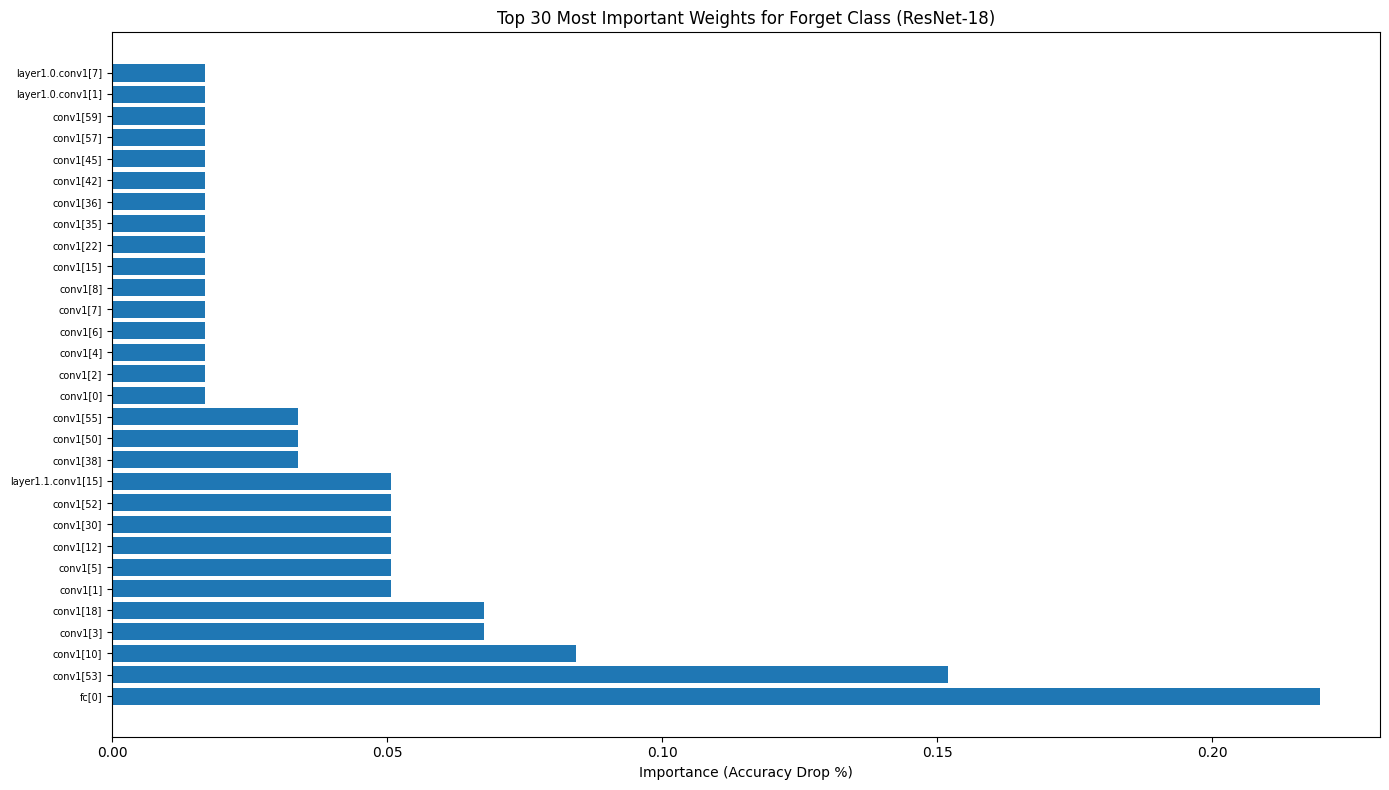


Weight importance plot saved as 'weight_importance_resnet18.png'

[STEP 5] Selecting top 5.0% important weights...

SELECTED TOP 5.0% IMPORTANT WEIGHTS
Total weights analyzed: 4804
Selected: 240

Top 20 most important:
  1. fc[0]: 0.2195% accuracy drop
  2. conv1[53]: 0.1520% accuracy drop
  3. conv1[10]: 0.0844% accuracy drop
  4. conv1[3]: 0.0675% accuracy drop
  5. conv1[18]: 0.0675% accuracy drop
  6. conv1[1]: 0.0507% accuracy drop
  7. conv1[5]: 0.0507% accuracy drop
  8. conv1[12]: 0.0507% accuracy drop
  9. conv1[30]: 0.0507% accuracy drop
  10. conv1[52]: 0.0507% accuracy drop
  11. layer1.1.conv1[15]: 0.0507% accuracy drop
  12. conv1[38]: 0.0338% accuracy drop
  13. conv1[50]: 0.0338% accuracy drop
  14. conv1[55]: 0.0338% accuracy drop
  15. conv1[0]: 0.0169% accuracy drop
  16. conv1[2]: 0.0169% accuracy drop
  17. conv1[4]: 0.0169% accuracy drop
  18. conv1[6]: 0.0169% accuracy drop
  19. conv1[7]: 0.0169% accuracy drop
  20. conv1[8]: 0.0169% accuracy drop

[STEP 6] App

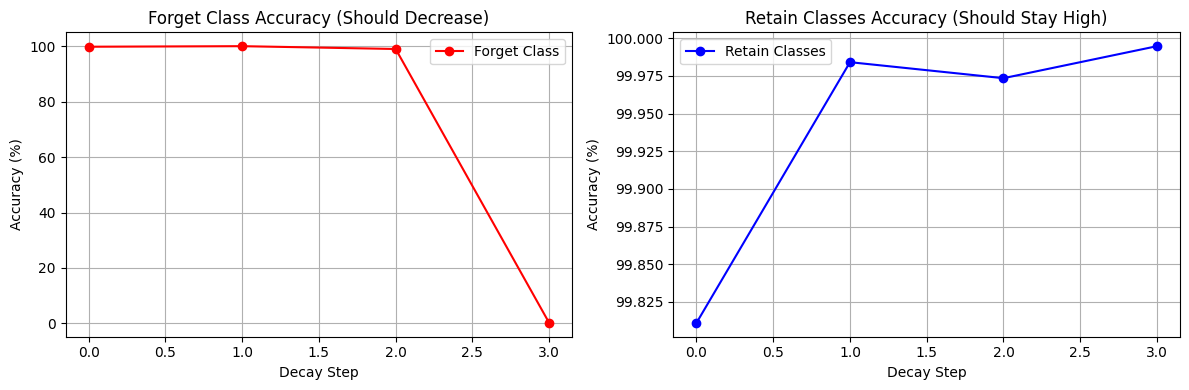


Plot saved as 'unlearning_results_resnet18.png'

Models saved:
  - unlearned_model_resnet18.pth
  - original_model_resnet18.pth


In [4]:
model, original_model, history = main()